In [ ]:
!git clone https://github.com/iiscleap/Coswara-Data.git

!pip3 install boto3 botocore
import boto3
from botocore.exceptions import ClientError

from sklearn.model_selection import train_test_split
from shutil import copyfile
import pandas as pd
import numpy as np
import datetime
import json
import copy
import glob
import os 

#root directory where coswara data is stored
coswara_dir = '/content/Coswara-Data/'
import glob
for each in os.listdir(coswara_dir):
    if os.path.isdir(os.path.join(coswara_dir,each)) and each != '.git':
        print(each)
        !cat {os.path.join(coswara_dir, each,'')}*.tar.gz.* > {os.path.join(coswara_dir, each,'')}combined_file.tar.gz
        !tar -xzf {os.path.join(coswara_dir, each,'')}combined_file.tar.gz -C {coswara_dir}
subset = glob.glob('/content/Coswara-Data/*/*.tar.gz.*') + glob.glob('/content/Coswara-Data/*/combined_data.tar.gz')

#[os.remove(x) for x in subset];
for x in subset: os.remove(x)

Cloning into 'Coswara-Data'...
remote: Enumerating objects: 11, done.
remote: Counting objects: 100% (11/11), done.
remote: Compressing objects: 100% (9/9), done.
remote: Total 529 (delta 2), reused 0 (delta 0), pack-reused 518
Receiving objects: 100% (529/529), 10.75 GiB | 44.04 MiB/s, done.
Resolving deltas: 100% (186/186), done.
Checking out files: 100% (125/125), done.
     |████████████████████████████████| 133kB 4.5MB/s 
     |████████████████████████████████| 7.4MB 6.7MB/s 
     |████████████████████████████████| 81kB 6.0MB/s 
     |████████████████████████████████| 153kB 41.6MB/s 
ERROR: requests 2.23.0 has requirement urllib3!=1.25.0,!=1.25.1,<1.26,>=1.21.1, but you'll have urllib3 1.26.4 which is incompatible.
ERROR: datascience 0.10.6 has requirement folium==0.2.1, but you'll have folium 0.8.3 which is incompatible.
  Found existing installation: urllib3 1.24.3
    Uninstalling urllib3-1.24.3:
      Successfully uninstalled urllib3-1.24.3
20200417
20200504
20200720
20200430


In [ ]:
coswara_metadata = pd.read_csv(coswara_dir+'combined_data.csv')
coswara_metadata

,id,a,covid_status,ep,g,l_c,l_l,l_s,rU,asthma,cough,smoker,ht,cold,diabetes,um,ihd,bd,st,fever,ftg,mp,loss_of_smell,test_status,pneumonia,diarrhoea,cld
0,DRBAZX64nuVtqBQf13gH7r36Mh52,26,healthy,y,female,United States,Madison,Wisconsin,n,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,Jw7YMfwGqMX22UbHh1TTgYMTYWs1,16,healthy,y,female,India,24 pargana,West Bengal,n,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,xa2v8z3Yzgb9dFrq2gEZz6oS7fh1,26,resp_illness_not_identified,y,male,India,Kolkata,West Bengal,n,True,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,xwHQrG0KwjTLJvBYVtVXfHp4JAd2,32,resp_illness_not_identified,y,male,Sri Lanka,Sri Jatawardanapura,Western Province,n,NaN,True,True,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,xKW2EpGmJcfigLecUTLVXEWQHPg2,22,healthy,y,male,India,Kolkata,West Bengal,n,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1498,Sy1VK1UgX0ZMcMJitgPal1sp8jj2,20,healthy,y,female,India,Bangalore,Karnataka,n,NaN,NaN,NaN,NaN,NaN,NaN,n,NaN,NaN,True,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1499,4drDZUlQcteX5StlFT2CXEL0N0L2,57,healthy,y,male,India,bangalore,Karnataka,n,NaN,NaN,NaN,NaN,NaN,True,n,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1500,qSDQMZj4iqhaRUz1SvwiUqyUzKH3,52,healthy,y,male,India,Bangalore,Karnataka,n,NaN,True,NaN,NaN,True,NaN,n,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1501,vX3NZt9tyQUhXgS4dlz55VGEMdU2,55,healthy,y,male,India,NaN,Karnataka,n,NaN,NaN,NaN,NaN,NaN,True,n,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [ ]:
set(coswara_metadata['covid_status'])

{'healthy',
 'no_resp_illness_exposed',
 'positive_asymp',
 'positive_mild',
 'positive_moderate',
 'recovered_full',
 'resp_illness_not_identified'}

In [ ]:
#utility functions for reformating dates/times

#take a folder name (which is the date all the data inside was collected) and split it up int Y, M ,D
break_up_date = lambda s: (s[0:4], s[4:6], s[6:])

#make datetime string - not sure if this is right but can fix it later
to_datestring = lambda Y,M,D : "{}-{}-{}".format(Y, M, D)

In [ ]:
#every folder here represents a date - we're gonna need this!
coswara_folders = [f for f in os.listdir(coswara_dir) if os.path.isdir(coswara_dir+f) and f[0]=='2']

#we want to know when every sample was collected
datestrings = {}

for folder in coswara_folders:
    Y,M,D = break_up_date(folder)
    datesting = to_datestring(Y,M,D)
    #print(datesting)
    for uid in os.listdir(coswara_dir+'/'+folder):
        datestrings[uid]=datesting

# Coswara Legend

"id":"User ID",
"a":"Age (number)",
"covid_status":"Health status (e.g. : positive_mild, healthy,etc.)",
"ep":"Proficient in English (y/n)",
"g":"Gender (male/female/other)" ,
"l_c":"Country",
"l_l":"Locality",
"l_s":"State",
"rU":"Returning User (y/n)",
"asthma":"Asthma (True/False)",
"cough":"Cough (True/False)",
"smoker":"Smoker (True/False)",
"test_status":"Status of COVID Test (p->Positive, n->Negative, na-> Not taken Test)",
"ht":"Hypertension  (True/False)",
"cold":"Cold  (True/False)",
"diabetes":"Diabetes  (True/False)",
"diarrhoea":"Diarrheoa  (True/False)",
"um":"Using Mask (y/n)",
"ihd":"Ischemic Heart Disease (True/False)",
"bd":"Breathing Difficulties (True/False)",
"st":"Sore Throat (True/False)",
"fever":"Fever (True/False)",
"ftg":"Fatigue (True/False)",
"mp":"Muscle Pain (True/False)",
"loss_of_smell":"Loss of Smell & Taste (True/False)",
"cld":"Chronic Lung Disease (True/False)",
"pneumonia":"Pneumonia (True/False)"

In [ ]:
#parse coswara metadata and convert to CDF

coswara_cdf = []
for idx, row in coswara_metadata.iterrows():

    #get patient info
    patient_info = {}
    patient_info['source'] = 'coswara'
    patient_info['patient_id'] = row['id']
    patient_info['cough_detected'] = np.nan
    patient_info['age']=row['a']
    patient_info['biological_sex']=row['g']
    patient_info['submission_date']= datestrings[row['id']]
    patient_info['pcr_test_date'] = np.nan
    patient_info['pcr_result_date'] = np.nan
    
    #check if patient has respiratory problems
    if (row['asthma']==True) or (row['cld']==True):
      patient_info['respiratory_condition']=True
    elif (row['asthma']==False) and (row['cld']==False):
      patient_info['respiratory_condition']=False
    else:
      patient_info['respiratory_condition']=np.nan

    if (row['mp']==True) or (row['fever']==True):
      patient_info['fever_or_muscle_pain']=True
    elif (row['mp']==False) and (row['fever']==False):
      patient_info['fever_or_muscle_pain']=False
    else:
      patient_info['fever_or_muscle_pain']=np.nan


    # TODO: Should we differentiate self-reported vs clinically validated symptoms?
    """
    #do they have symptoms? - check for top 3 symptoms: cough, fever, and shortness of breath (breathing difficulties?)
    if (row['cough']==True) or (row['fever']==True) or (row['bd']==True):
      patient_info['covid_symptoms']=True
    elif (row['cough']==False) and (row['fever']==False) and (row['bd']==False):
      patient_info['covid_symptoms']=False
    else:
      patient_info['covid_symptoms']=np.nan
    """
    # TODO: Add asthma / bronchitis 

    # Reference: Coswara questionnaire questions and answers
    # Have you taken a COVID-19 test?
    # Current status: 
    if row['covid_status']=='positive_mild':
      # Tested positive in my last test
      # Mild symptoms
      patient_info['pcr_test_result'] = 'positive'
      patient_info['covid_symptoms'] = True
      patient_info['covid_symptoms_severity'] = 'mild'
      patient_info['respiratory_condition'] = np.nan
    elif row['covid_status']=='positive_moderate':
      # Tested positive in my last test
      # Moderate symptoms
      patient_info['pcr_test_result'] = 'positive'
      patient_info['covid_symptoms'] = True
      patient_info['covid_symptoms_severity'] = 'moderate'
      patient_info['respiratory_condition'] = np.nan
    elif row['covid_status']=='positive_asymp':
      # Tested positive in my last test
      # No symptoms (asymptomatic)
      patient_info['pcr_test_result'] = 'positive'
      patient_info['covid_symptoms'] = False
      patient_info['covid_symptoms_severity'] = np.nan
      patient_info['respiratory_condition'] = np.nan
    elif row['covid_status']=='recovered_full':
      # Tested positive in my last test 
      # Had symptoms and have recovered fully
      # OR 
      # Tested negative in my last test
      # Had previously tested positive but have tested negative now and recovered fully
      patient_info['pcr_test_result'] = 'recovered'
      patient_info['covid_symptoms'] = False
      patient_info['covid_symptoms_severity'] = np.nan
      patient_info['respiratory_condition'] = np.nan
    elif row['covid_status'] == 'resp_illness_not_identified':
      # Tested negative in my last test OR Never taken a test
      # Have other pre-existing respiratory illnesses
      patient_info['pcr_test_result'] = np.nan
      patient_info['covid_symptoms'] = False
      patient_info['covid_symptoms_severity'] = np.nan
      patient_info['respiratory_condition'] = True
    elif row['covid_status'] == 'no_resp_illness_exposed':
      # Tested negative in my last test OR Never taken a test
      # Have no respiratory illness but I may have been exposed to the virus through contact
      patient_info['pcr_test_result'] = np.nan
      patient_info['covid_symptoms'] = False
      patient_info['covid_symptoms_severity'] = np.nan
      patient_info['respiratory_condition'] = False
    elif row['covid_status']=='healthy':
      # Tested negative in my last test 
      # Do not have any respiratory illness
      patient_info['pcr_test_result'] = 'negative'
      patient_info['covid_symptoms'] = False
      patient_info['covid_symptoms_severity'] = np.nan
      patient_info['respiratory_condition'] = False
    else:
      # Never taken a test
      patient_info['pcr_test_result'] = 'untested'
      patient_info['covid_symptoms'] = np.nan
      patient_info['covid_symptoms_severity'] = np.nan
      patient_info['respiratory_condition'] = np.nan

    patient_info['pcr_test_result_inferred'] = patient_info['pcr_test_result']

    #every patient has their own folder with multiple files
    patient_folder = coswara_dir+patient_info['submission_date'].replace('-','') +'/'+ row['id']+'/'
    
    #each patient has many files, we only care about the ones containing a caugh
    cough_paths = [patient_folder+f for f in os.listdir(patient_folder) if 'cough' in f]

    for path in cough_paths:
      #make a copy of patient info so we can put in a different filepath for each patient
      info_copy = copy.deepcopy(patient_info) 

      
      #remove 'content/' from the filepath to make it reproducible outside colab
      path = path.replace('/content/','')

      #now we give it a unique filepath
      info_copy['cough_path']=path
      coswara_cdf.append(info_copy)
      #print(os.path.exists(path))

# Preprocess CDF 

Because Coswara includes multiple cough files from the same patient, we split the dataset by patient ID. 

This means a single patient's files will only ever be in the train or the test set to prevent data leakage. 

In [ ]:
df = pd.DataFrame(coswara_cdf)
df.head(2)

,source,patient_id,cough_detected,age,biological_sex,submission_date,pcr_test_date,pcr_result_date,respiratory_condition,fever_or_muscle_pain,pcr_test_result,covid_symptoms,pcr_test_result_inferred,cough_path,covid_symptoms_severity
0,coswara,DRBAZX64nuVtqBQf13gH7r36Mh52,NaN,26,female,2020-04-30,NaN,NaN,False,NaN,negative,False,negative,Coswara-Data/20200430/DRBAZX64nuVtqBQf13gH7r36...,NaN
1,coswara,DRBAZX64nuVtqBQf13gH7r36Mh52,NaN,26,female,2020-04-30,NaN,NaN,False,NaN,negative,False,negative,Coswara-Data/20200430/DRBAZX64nuVtqBQf13gH7r36...,NaN


In [ ]:
print('{}% of dataframe columns have NaN for respiratory_condition'.format(100*len(df[df['respiratory_condition'].isnull()])/len(df)))
print('{}% of dataframe columns have NaN for fever_muscle_pain'.format(100*len(df[df['fever_or_muscle_pain'].isnull()])/len(df)))
print('{}% of dataframe columns have NaN for covid_symptoms'.format(100*len(df[df['covid_symptoms'].isnull()])/len(df)))
print('{}% of dataframe columns have NaN for pcr_test_result'.format(100*len(df[df['pcr_test_result'].isnull()])/len(df)))

8.516300731869594% of dataframe columns have NaN for respiratory_condition
95.0765136393879% of dataframe columns have NaN for fever_muscle_pain
11.57684630738523% of dataframe columns have NaN for covid_symptoms
11.57684630738523% of dataframe columns have NaN for pcr_test_result


By right, each patient should appear 2 times in the dataframe - one heavy cough and one shallow cough. 

For some reason, some patients appear 3 times and some patients appear 1 time. Because these are a negligible number of the total records we chose to discard these audio files. 

(array([1.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 1.501e+03,
        0.000e+00, 0.000e+00, 0.000e+00, 1.000e+00]),
 array([1. , 1.2, 1.4, 1.6, 1.8, 2. , 2.2, 2.4, 2.6, 2.8, 3. ]),
 <a list of 10 Patch objects>)

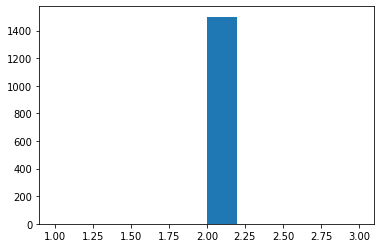

In [ ]:
counts = df.loc[:, ['patient_id', 'source']].groupby('patient_id').count()['source']

from matplotlib.pyplot import hist
hist(counts) 

In [ ]:
df = df.sort_values('patient_id')
temp = df.loc[:, ['patient_id', 'source']].groupby('patient_id').count().reset_index()
ids = temp.loc[temp['source'] == 2, 'patient_id']
df = df.merge(ids, how = 'inner', on = 'patient_id')

We restructure the data so that each row corresponds to 1 patient; the heavy and shallow cough paths are provided as separate fields

In [ ]:
def split_rows_by_patient_id(df):
  """
  Input: pd.DataFrame of rows. Each row = 1 cough
  Output: train, test split. Each row = 1 patient, heavy + shallow cough
  """
  out = []
  labels = []

  # Split dataframe into pairs of heavy/shallow cough for the same patient ID
  df = df.sort_values('patient_id')
  for i in range(0, len(df), 2):
    assert i % 2 == 0 
    assert df.loc[i,"patient_id"] == df.loc[i+1,"patient_id"], str(i) + " " + df.loc[i,"patient_id"] + " " + df.loc[i+1,"patient_id"]
    row = df.iloc[i,:].copy()
    next_row = df.iloc[i+1,:].copy()
    row_is_heavy = ('heavy' in row['cough_path'])
    row['cough_path_heavy'] = row['cough_path'] if row_is_heavy else next_row['cough_path']
    row['cough_path_shallow'] = next_row['cough_path'] if row_is_heavy else row['cough_path']
    # We keep the original field for consistency. Defaults to heavy cough. 
    row['cough_path'] = row['cough_path_heavy']
    out += [row]
    labels += [(df.loc[i,"pcr_test_result"] if df.loc[i,"pcr_test_result"] == "positive" else "untested")]
  
  # Split the pairs into a train/test set
  cdf_train, cdf_val = train_test_split(out, test_size=0.2, random_state = 0, stratify = labels)
  df_cdf_train = pd.DataFrame(cdf_train, 
                              columns = list(df.columns) + ['cough_path_heavy', 'cough_path_shallow'])
  df_cdf_val = pd.DataFrame(cdf_val, 
                              columns = list(df.columns) + ['cough_path_heavy', 'cough_path_shallow'])

  return df_cdf_train, df_cdf_val

In [ ]:
cdf_train, cdf_val = split_rows_by_patient_id(df)
print(len(cdf_train), len(cdf_val))

1200 301


In [ ]:
print(cdf_train.loc[0, 'cough_path'])
print(cdf_train.loc[0, 'cough_path_heavy'])
print(cdf_train.loc[0, 'cough_path_shallow'])

Coswara-Data/20200820/01OCEf1yB4czsq8ygRoT51s96Ba2/cough-heavy.wav
Coswara-Data/20200820/01OCEf1yB4czsq8ygRoT51s96Ba2/cough-heavy.wav
Coswara-Data/20200820/01OCEf1yB4czsq8ygRoT51s96Ba2/cough-shallow.wav


In [ ]:
# Check that train and val splits have approx same distribution of labels
print(cdf_train.groupby(['pcr_test_result']).count()['source'])
print(cdf_val.groupby(['pcr_test_result']).count()['source'])

pcr_test_result
negative     958
positive      86
recovered     21
Name: source, dtype: int64
pcr_test_result
negative     238
positive      22
recovered      2
Name: source, dtype: int64


# Upload splits to S3

In [ ]:
#get rid of all of this in case we mess up
!rm -rf virufy-cdf-coswara{,-val}

In [ ]:
#make folders for the training and validation splits
!mkdir virufy-cdf-coswara{,-val}

In [ ]:
#loop through training split and copy files to 'virufy-cdf-coswara-train'
def export(cdf_dataset, name):
    data = []
    for index, row in cdf_dataset.iterrows():
        row_data = dict(row)
        original_path = row_data['cough_path']
        # Sample original path: Coswara-Data/20200430/DRBAZX64nuVtqBQf13gH7r36Mh52/cough-shallow.wav
        # 20200430 - Date
        # DRB....  - patient ID
        # cough-shallow.wav / cough_heavy.wav - cough type
        # Parse into new file path: {dateE}-{patient_id}-{cough_type}
        tokens = original_path.split('/')
        new_path = name + '/' + '-'.join(tokens[-3:])
        copyfile(original_path, new_path)
        row_data['cough_path'] = new_path
        data.append(row_data)

    df = pd.DataFrame(data)
    df.to_csv(name + ".csv")
    return df
  
export(cdf_train, "virufy-cdf-coswara")
export(cdf_val, "virufy-cdf-coswara-val")

,source,patient_id,cough_detected,age,biological_sex,submission_date,pcr_test_date,pcr_result_date,respiratory_condition,fever_or_muscle_pain,pcr_test_result,covid_symptoms,pcr_test_result_inferred,cough_path,covid_symptoms_severity,cough_path_heavy,cough_path_shallow
0,coswara,g6L8s5Dtq8eIYUTeRWHq0Q7w5L32,NaN,36,female,2020-04-13,NaN,NaN,False,NaN,negative,False,negative,virufy-cdf-coswara-val/20200413-g6L8s5Dtq8eIYU...,NaN,Coswara-Data/20200413/g6L8s5Dtq8eIYUTeRWHq0Q7w...,Coswara-Data/20200413/g6L8s5Dtq8eIYUTeRWHq0Q7w...
1,coswara,RUG3ss3JaEVElB4LvuOrW8wC1pD2,NaN,25,female,2020-04-24,NaN,NaN,False,NaN,negative,False,negative,virufy-cdf-coswara-val/20200424-RUG3ss3JaEVElB...,NaN,Coswara-Data/20200424/RUG3ss3JaEVElB4LvuOrW8wC...,Coswara-Data/20200424/RUG3ss3JaEVElB4LvuOrW8wC...
2,coswara,49Ih3xxOmCT53KfYuC2BKGvSAi13,NaN,30,male,2020-12-21,NaN,NaN,False,NaN,negative,False,negative,virufy-cdf-coswara-val/20201221-49Ih3xxOmCT53K...,NaN,Coswara-Data/20201221/49Ih3xxOmCT53KfYuC2BKGvS...,Coswara-Data/20201221/49Ih3xxOmCT53KfYuC2BKGvS...
3,coswara,EVWPvD070lhgBsNRXIJ0TsQj3iz2,NaN,40,male,2020-05-04,NaN,NaN,False,NaN,negative,False,negative,virufy-cdf-coswara-val/20200504-EVWPvD070lhgBs...,NaN,Coswara-Data/20200504/EVWPvD070lhgBsNRXIJ0TsQj...,Coswara-Data/20200504/EVWPvD070lhgBsNRXIJ0TsQj...
4,coswara,FGRDO4IBbAejR0WHD5YbkXTCasg2,NaN,26,male,2020-04-13,NaN,NaN,False,NaN,negative,False,negative,virufy-cdf-coswara-val/20200413-FGRDO4IBbAejR0...,NaN,Coswara-Data/20200413/FGRDO4IBbAejR0WHD5YbkXTC...,Coswara-Data/20200413/FGRDO4IBbAejR0WHD5YbkXTC...
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
296,coswara,fuCq7eA5CPYcnRpJqc0hFSr8klr2,NaN,26,male,2020-08-20,NaN,NaN,False,NaN,negative,False,negative,virufy-cdf-coswara-val/20200820-fuCq7eA5CPYcnR...,NaN,Coswara-Data/20200820/fuCq7eA5CPYcnRpJqc0hFSr8...,Coswara-Data/20200820/fuCq7eA5CPYcnRpJqc0hFSr8...
297,coswara,uJEVN893b2Pntd1Ck3cdY7RZZRo1,NaN,26,male,2020-04-17,NaN,NaN,False,NaN,negative,False,negative,virufy-cdf-coswara-val/20200417-uJEVN893b2Pntd...,NaN,Coswara-Data/20200417/uJEVN893b2Pntd1Ck3cdY7RZ...,Coswara-Data/20200417/uJEVN893b2Pntd1Ck3cdY7RZ...
298,coswara,GjdjAvKrnbRRRX1KbioknjMVLNx2,NaN,41,female,2020-05-04,NaN,NaN,True,NaN,NaN,NaN,NaN,virufy-cdf-coswara-val/20200504-GjdjAvKrnbRRRX...,NaN,Coswara-Data/20200504/GjdjAvKrnbRRRX1KbioknjMV...,Coswara-Data/20200504/GjdjAvKrnbRRRX1KbioknjMV...
299,coswara,2SLFvRD3jTUJc8iOMnN2XHG3uXv1,NaN,23,male,2020-04-15,NaN,NaN,True,NaN,NaN,NaN,NaN,virufy-cdf-coswara-val/20200415-2SLFvRD3jTUJc8...,NaN,Coswara-Data/20200415/2SLFvRD3jTUJc8iOMnN2XHG3...,Coswara-Data/20200415/2SLFvRD3jTUJc8iOMnN2XHG3...


In [ ]:
!zip -rq virufy-cdf-coswara.zip virufy-cdf-coswara
!zip -rq virufy-cdf-coswara-val.zip virufy-cdf-coswara-val

In [ ]:
def upload_file(file_name, bucket, s3,object_name=None):
    """Upload a file to an S3 bucket

    :param file_name: File to upload
    :param bucket: Bucket to upload to
    :param s3: boto s3 client
    :param object_name: S3 object name. If not specified then file_name is used
    :return: True if file was uploaded, else False
    """

    # If S3 object_name was not specified, use file_name
    if object_name is None:
        object_name = file_name

    
    try:
        response = s3.upload_file(file_name, bucket, object_name)
    except ClientError as e:
        logging.error(e)
        return False
    return True

In [ ]:
from getpass import getpass

aws_access_key_id = getpass("Please enter s3 access key: ")
aws_secret_access_key = getpass("Please enter s3 secret key: ")

s3_client = boto3.client('s3', aws_access_key_id=aws_access_key_id , aws_secret_access_key= aws_secret_access_key)

#upload train set and metadata
assert upload_file('virufy-cdf-coswara.csv', 'virufy-cdf-coswara', s3_client)
assert upload_file('virufy-cdf-coswara.zip', 'virufy-cdf-coswara', s3_client)

#upload test set and metadata
assert upload_file('virufy-cdf-coswara-val.csv', 'virufy-cdf-coswara', s3_client)
assert upload_file('virufy-cdf-coswara-val.zip', 'virufy-cdf-coswara', s3_client)

Please enter s3 access key: ··········
Please enter s3 secret key: ··········
